In [2]:
import os
import pandas as pd
import numpy as np
import random
import shutil
from shutil import copyfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
import matplotlib.patches as mpatches

In [3]:
import os

base_dir = "C:\\Users\\User\\pythonfinal"


directories_list = os.listdir(os.path.join(base_dir, "Agricultural-crops"))

len_labels = len(directories_list)
print(f"Total Class Labels = {len_labels}")

vis_images = []; vis_labels =[]
length_file_list = []; label_list = []

for item in directories_list:
    
    item_dir = os.path.join(base_dir, "Agricultural-crops", item)
    
    item_files = os.listdir(item_dir)

    len_per_label = len(os.listdir(item_dir))
    
    length_file_list.append(len_per_label)
    label_list.append(item)
    

    vis_images.append(os.path.join(item_dir, item_files[0]))

    vis_labels.append(item)


df_temp = pd.DataFrame({'Labels': label_list, 'Number of Images': length_file_list}).sort_values(by='Number of Images', ascending=False)
print(df_temp)


Total Class Labels = 30
                 Labels  Number of Images
19  Pearl_millet(bajra)                39
26        Tobacco-plant                33
8                cotton                32
3                Cherry                32
15                maize                31
1                banana                31
9              Cucumber                31
29                wheat                31
12                jowar                30
5                 clove                30
17           Olive-tree                30
22             soyabean                30
7          Coffee-plant                29
21                 rice                29
14                Lemon                28
16          mustard-oil                28
28  vigna-radiati(Mung)                27
27               tomato                26
11                 gram                25
6               coconut                25
20            pineapple                25
23            sugarcane                25
24        

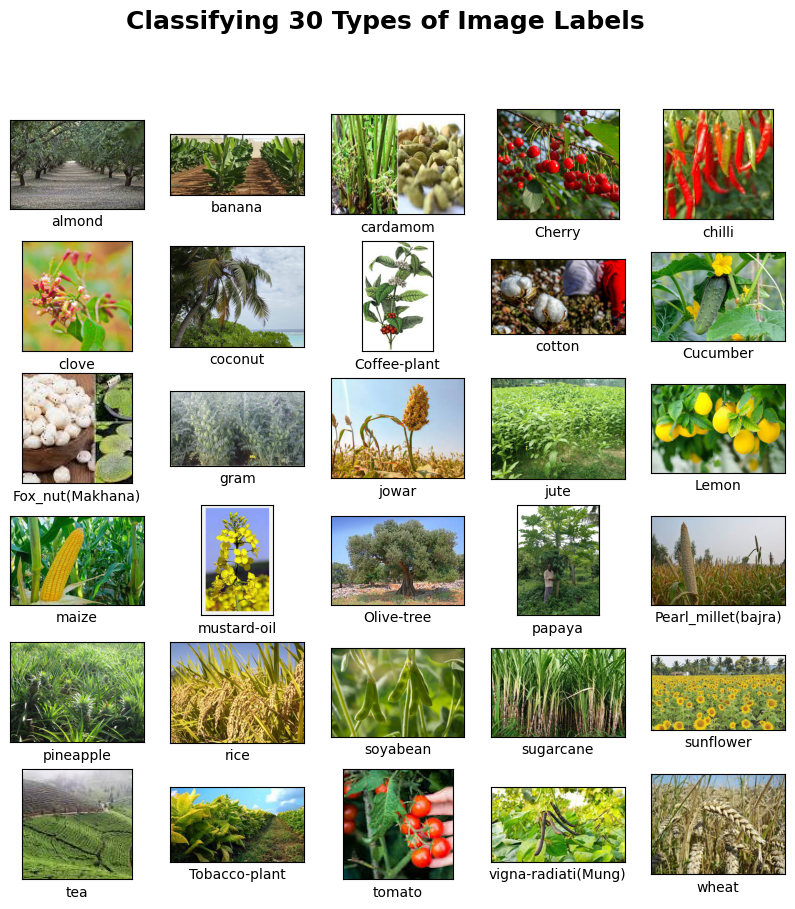

In [4]:
plt.figure(figsize=(10,10))
for i in range(len(vis_labels)):
    plt.subplot(6,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = mpimg.imread(vis_images[i])
    plt.imshow(img)
    plt.xlabel(vis_labels[i])
    plt.suptitle(f"Classifying {len_labels} Types of Image Labels",fontsize=18, fontweight='bold')
plt.show()

In [6]:
import os
import random
from shutil import copyfile

def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
    selected_file_names = []
    all_file_names = os.listdir(SOURCE_DIR)
    for file_name in all_file_names:
        file_path = os.path.join(SOURCE_DIR, file_name)
        size = os.path.getsize(file_path)
        if size != 0:
            selected_file_names.append(file_name)
        else:
            print(f"{file_name} is zero length, so ignoring.")

    random.seed(42)
    selected_train_files = random.sample(selected_file_names, int(SPLIT_SIZE * len(selected_file_names)))
    selected_val_files = [x for x in selected_file_names if x not in selected_train_files]

    for file_name in selected_train_files:
        source = os.path.join(SOURCE_DIR, file_name)
        destination = os.path.join(TRAINING_DIR, file_name)
        copyfile(source, destination)

    for file_name in selected_val_files:
        source = os.path.join(SOURCE_DIR, file_name)
        destination = os.path.join(VALIDATION_DIR, file_name)
        copyfile(source, destination)

def create_train_val_dirs(root_path, split_size=0.9):
    for item in directories_list:
        source_dir = os.path.join(base_dir, "Agricultural-crops", item)
        training_dir = os.path.join(root_path, f'_MODELLING/training/{item}')
        validation_dir = os.path.join(root_path, f'_MODELLING/validation/{item}')

        os.makedirs(training_dir, exist_ok=True)
        os.makedirs(validation_dir, exist_ok=True)

        split_data(source_dir, training_dir, validation_dir, split_size)
    print(f"Created training and validation directories containing images at split size of {split_size}")

create_train_val_dirs('/kaggle/working', split_size=0.8)


Created training and validation directories containing images at split size of 0.8


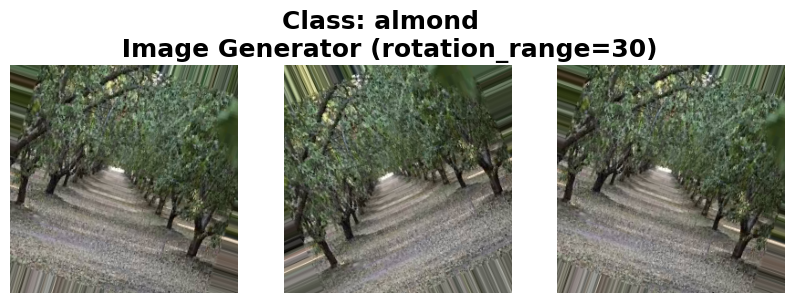

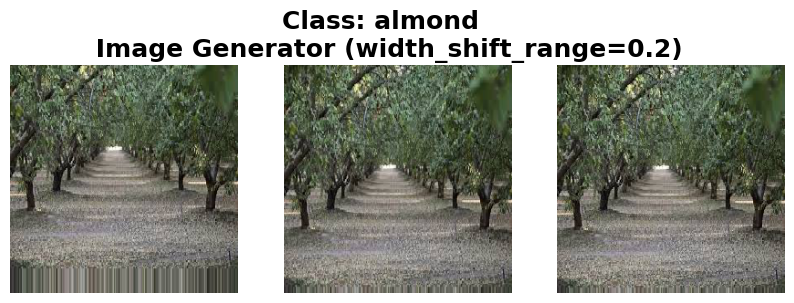

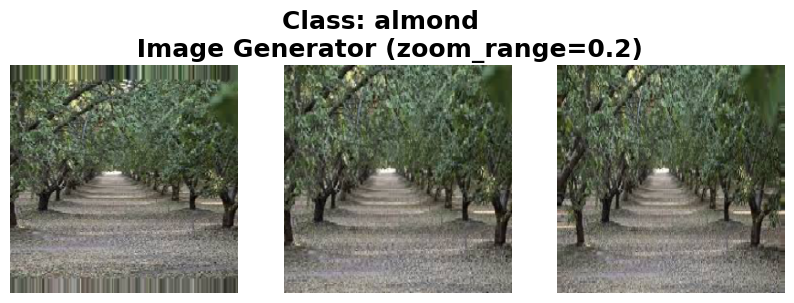

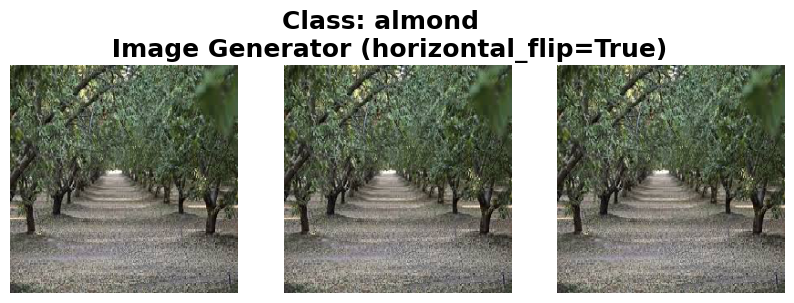

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def show_ImageDataGenerator(vis_images, vis_labels, image_index):
    class_label = vis_labels[image_index]
    img = tf.keras.preprocessing.image.load_img(vis_images[image_index], target_size=(250, 250))
    img_tensor = tf.keras.preprocessing.image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)

    def show_image(datagen, param):
        pic = datagen.flow(img_tensor, batch_size=1)
        plt.figure(figsize=(10, 3.5))
        # Plots our figures
        for i in range(1, 4):
            plt.subplot(1, 3, i)
            batch = next(pic)
            image_ = batch[0].astype('uint8')
            plt.imshow(image_)
            plt.axis('off')
        plt.suptitle(f"Class: {class_label} \n Image Generator ({param})", fontsize=18, fontweight='bold')
        plt.show()

    datagen = ImageDataGenerator(rotation_range=30)
    show_image(datagen, "rotation_range=30")

    datagen = ImageDataGenerator(width_shift_range=0.2)
    show_image(datagen, "width_shift_range=0.2")

    datagen = ImageDataGenerator(zoom_range=0.2)
    show_image(datagen, "zoom_range=0.2")

    datagen = ImageDataGenerator(horizontal_flip=True)
    show_image(datagen, "horizontal_flip=True")


show_ImageDataGenerator(vis_images, vis_labels, image_index=0)


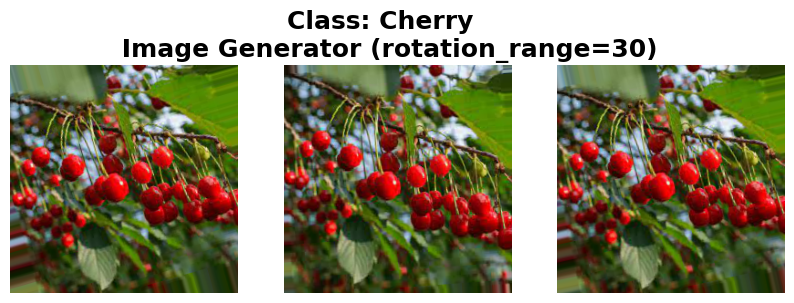

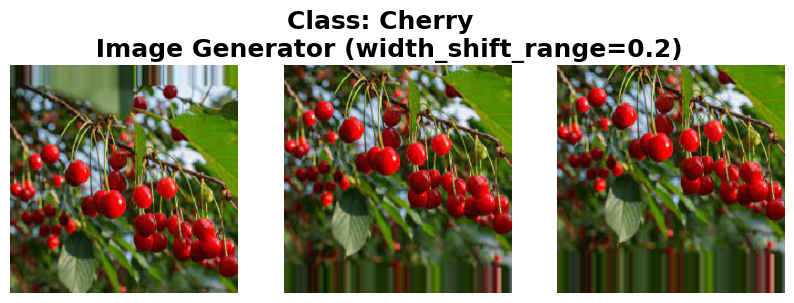

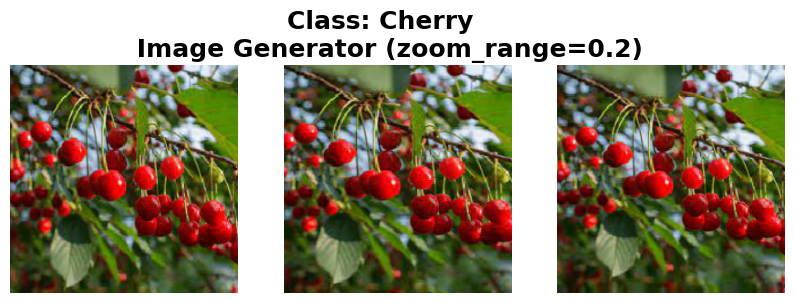

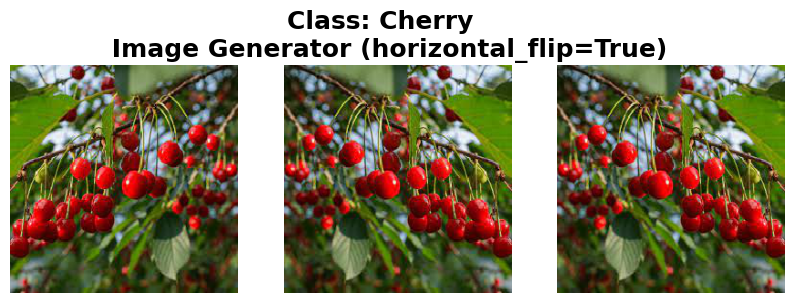

In [8]:
show_ImageDataGenerator(vis_images, vis_labels, image_index = 3)

# Train_Validation

In [9]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )


    train_generator = train_datagen.flow_from_directory(
        directory=TRAINING_DIR,
        batch_size=32,
        class_mode='binary',  # Changed to binary for binary classification
        target_size=(150, 150),
        shuffle=True  # Shuffle data to merge original and augmented images
    )


    validation_datagen = ImageDataGenerator(rescale=1./255)

    validation_generator = validation_datagen.flow_from_directory(
        directory=VALIDATION_DIR,
        batch_size=32,
        class_mode='binary',  # Changed to binary for binary classification
        target_size=(150, 150),
        shuffle=False  # No need to shuffle validation data
    )

    return train_generator, validation_generator

training_dir = os.path.join('/kaggle/working', '_MODELLING', 'training')
validation_dir = os.path.join('/kaggle/working', '_MODELLING', 'validation')

train_generator, validation_generator = train_val_generators(training_dir, validation_dir)


Found 731 images belonging to 30 classes.
Found 177 images belonging to 30 classes.


In [10]:
training_dir = os.path.join('/kaggle/working', '_MODELLING', 'training')
validation_dir = os.path.join('/kaggle/working', '_MODELLING', 'validation')

print(validation_dir)

/kaggle/working\_MODELLING\validation


In [11]:
train_generator, validation_generator = train_val_generators(training_dir, validation_dir)

Found 731 images belonging to 30 classes.
Found 177 images belonging to 30 classes.


# CNN 

In [12]:
cnn = tf.keras.models.Sequential()

In [38]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout

xavier_initializer = tf.keras.initializers.GlorotUniform()

cnn = tf.keras.models.Sequential([
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=[128, 128, 3], kernel_initializer=xavier_initializer),
    BatchNormalization(),
    
    Conv2D(filters=32, kernel_size=3, activation='relu', kernel_initializer=xavier_initializer),
    BatchNormalization(),
    
    MaxPooling2D(pool_size=2, strides=2),
    
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_initializer=xavier_initializer),
    BatchNormalization(),
    
    Conv2D(filters=64, kernel_size=3, activation='relu', kernel_initializer=xavier_initializer),
    BatchNormalization(),
    
    MaxPooling2D(pool_size=2, strides=2),
    
    Conv2D(filters=128, kernel_size=3, padding='same', activation='relu', kernel_initializer=xavier_initializer),
    BatchNormalization(),
    
    Conv2D(filters=128, kernel_size=3, activation='relu', kernel_initializer=xavier_initializer),
    BatchNormalization(),
    
    MaxPooling2D(pool_size=2, strides=2),
    
    Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', kernel_initializer=xavier_initializer),
    BatchNormalization(),
    
    Conv2D(filters=256, kernel_size=3, activation='relu', kernel_initializer=xavier_initializer),
    BatchNormalization(),
    
    MaxPooling2D(pool_size=2, strides=2),
    
    Conv2D(filters=512, kernel_size=3, padding='same', activation='relu', kernel_initializer=xavier_initializer),
    BatchNormalization(),
    
    MaxPooling2D(pool_size=2, strides=2),
    
    Dropout(0.5),
    Flatten(),
    
    Dense(units=1024, activation='relu', kernel_initializer=xavier_initializer),
    BatchNormalization(),
    
    Dropout(0.5),
    
    Dense(units=len_labels, activation='softmax')
])

cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [39]:
cnn.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss = 'sparse_categorical_crossentropy',
            metrics=['accuracy'])

In [40]:
cnn.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_38 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 126, 126, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 63, 63, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 63, 63, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 61, 61, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 30, 30, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 30, 30, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 6, 6, 512)      │     1,180,16

 Total params: 7,112,766 (27.13 MB)

 Trainable params: 7,107,774 (27.11 MB)

 Non-trainable params: 4,992 (19.50 KB)

In [82]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.95):
            print("\nReached 95% accuracy so cancelling training!")
            self.model.stop_training = True
callbacks = myCallback()

In [83]:
cnn.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss = 'sparse_categorical_crossentropy',
            metrics=['accuracy'])

In [90]:
history_1 =cnn.fit(train_generator,
                    epochs=10,
                    validation_data=validation_generator,
                    callbacks=callbacks)

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9129 - loss: 0.2777 - val_accuracy: 0.6836 - val_loss: 1.7647
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9029 - loss: 0.2957 - val_accuracy: 0.6836 - val_loss: 1.6414
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9046 - loss: 0.2692 - val_accuracy: 0.6893 - val_loss: 1.5924
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9212 - loss: 0.2456 - val_accuracy: 0.6893 - val_loss: 1.5439
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9145 - loss: 0.2598 - val_accuracy: 0.7006 - val_loss: 1.6031
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9181 - loss: 0.2421 - val_accuracy: 0.7006 - val_loss: 1.5264
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9311 - loss: 0.2084 - val_accuracy: 0.6893 - val_loss: 1.6281
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9206 - loss: 0.2676 - val_accuracy: 0.6836 - val_loss:

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 297ms/step
                     precision    recall  f1-score   support

             Cherry       1.00      1.00      1.00         7
       Coffee-plant       1.00      0.50      0.67         6
           Cucumber       0.75      0.43      0.55         7
   Fox_nut(Makhana)       0.83      1.00      0.91         5
              Lemon       1.00      0.67      0.80         6
         Olive-tree       0.75      0.50      0.60         6
Pearl_millet(bajra)       1.00      0.62      0.77         8
      Tobacco-plant       0.50      0.71      0.59         7
             almond       1.00      0.60      0.75         5
             banana       0.71      0.71      0.71         7
           cardamom       0.29      0.40      0.33         5
             chilli       1.00      0.60      0.75         5
              clove       0.83      0.83      0.83         6
            coconut       0.29      0.80      0.42         5
             cotton       1.00      0.71     

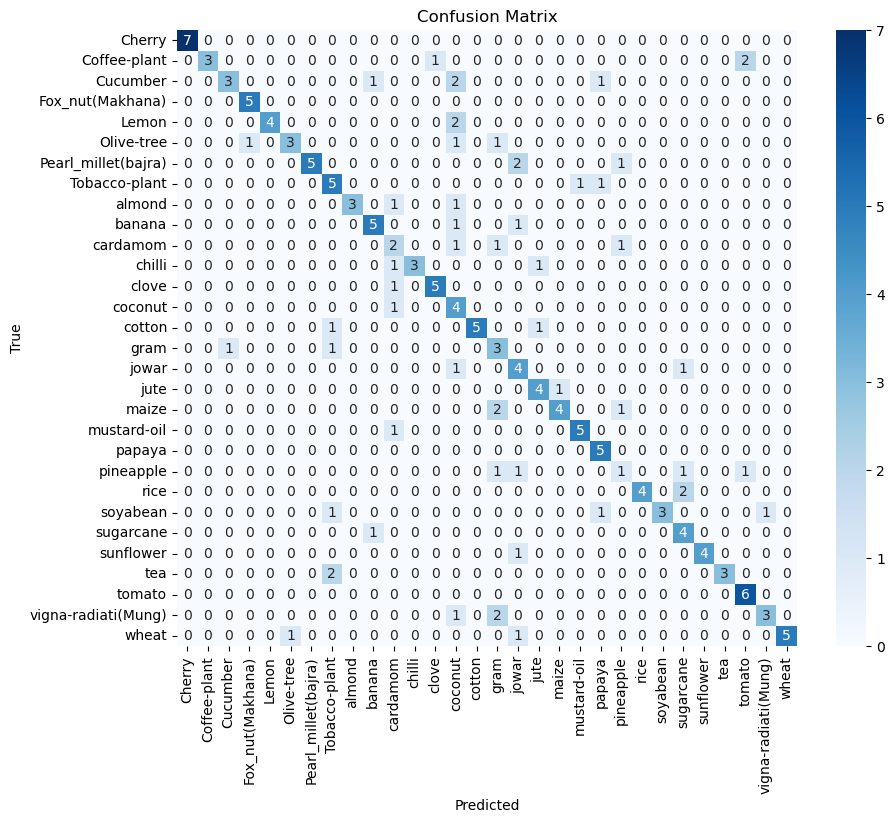

In [91]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
y_true = validation_generator.classes
y_pred = cnn.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
class_labels = list(validation_generator.class_indices.keys())

report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print(report)

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


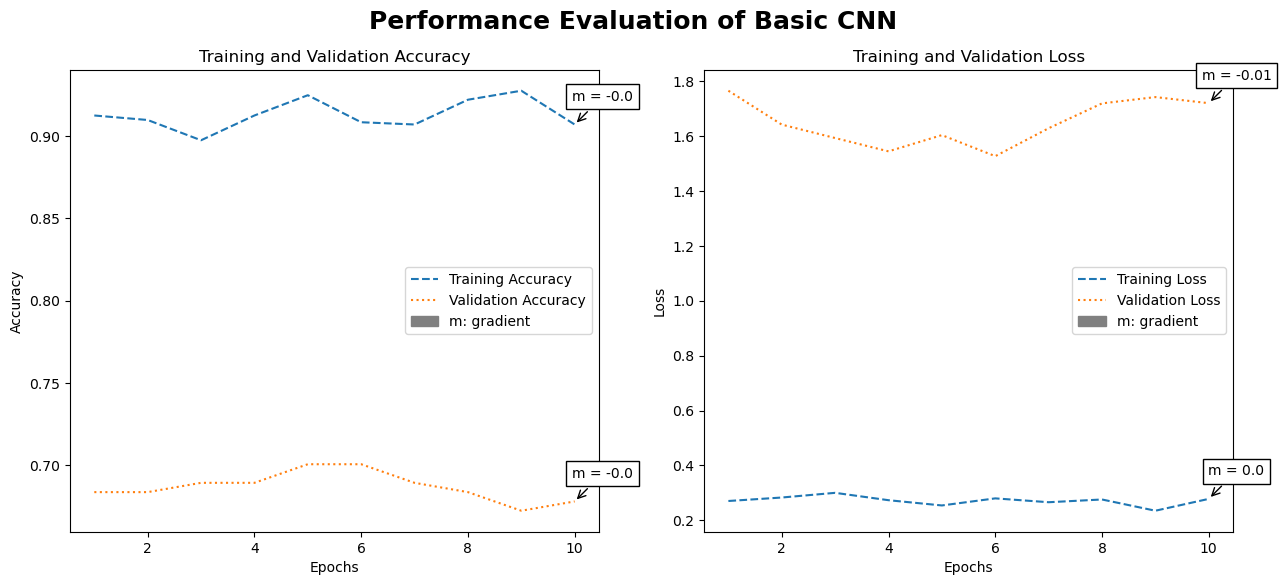

In [92]:
def vis_evaluation(history_dict, model_name):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    epochs = range(1, len(history_dict['accuracy'])+1)

    def get_gradient(y_arr, epochs):
        return round((y_arr[-1] - y_arr[0]) / (epochs[-1] - epochs[0]),2)

    def vis_sub_evaluation(n, Accuracy, train_acc, val_acc, epochs):
        axs[n].plot(epochs, train_acc, label=f'Training {Accuracy}', ls='--')
        axs[n].plot(epochs, val_acc, label=f'Validation {Accuracy}', ls='dotted')

        axs[n].set_title(f'Training and Validation {Accuracy}')
        axs[n].set_xlabel('Epochs')
        axs[n].set_ylabel(Accuracy)
        
        handles, labels = axs[n].get_legend_handles_labels()
        m_patch = mpatches.Patch(color='grey',label='m: gradient')
        handles.append(m_patch) 
        axs[n].legend(handles=handles)
        
        def annotate_box(train_acc):
            return AnnotationBbox(TextArea(f"m = {get_gradient(train_acc, epochs)}"), (epochs[-1], train_acc[-1]),
                            xybox=(20, 20),
                            xycoords='data',
                            boxcoords="offset points",
                            arrowprops=dict(arrowstyle="->"))
        axs[n].add_artist(annotate_box(train_acc))
        axs[n].add_artist(annotate_box(val_acc))

    train_acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    vis_sub_evaluation(0, 'Accuracy', train_acc, val_acc, epochs)

    train_loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    vis_sub_evaluation(1, 'Loss', train_loss, val_loss, epochs)
    
    plt.suptitle(f"Performance Evaluation of {model_name}",fontsize=18, fontweight='bold')
    plt.show()
    
history_dict_1 = history_1.history
vis_evaluation(history_dict_1, 'Basic CNN')

# PreTrained CNN model : VGG16

In [93]:
from tensorflow.keras.applications import VGG16

pre_trained_model = VGG16(include_top=False,weights='imagenet', input_shape=(150, 150, 3))
for layer in pre_trained_model.layers:
    layer.trainable = False
    
total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 14,714,688 total parameters in this model.
There are 0 trainable parameters in this model.


In [94]:
last_output = pre_trained_model.output
print('last layer output: ', last_output)

print(f"The pretrained model has type: {type(pre_trained_model)}")

last layer output:  <KerasTensor shape=(None, 4, 4, 512), dtype=float32, sparse=False, name=keras_tensor_205>
The pretrained model has type: <class 'keras.src.models.functional.Functional'>


In [95]:
from tensorflow.keras import Model
def transfer_learning(last_output, pre_trained_model):
    x = tf.keras.layers.Flatten()(last_output)

    x = tf.keras.layers.Dense(1024, activation='relu')(x)

    x = tf.keras.layers.Dropout(0.5)(x)  

    x = tf.keras.layers.Dense(len_labels, activation='softmax')(x)          

    model = Model(inputs=pre_trained_model.input, outputs=x)
    
    return model

In [96]:
model_2 = transfer_learning(last_output, pre_trained_model)
model_2.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1024)           │     8,389,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 30)             │        30,750 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,135,070 (88.25 MB)

 Trainable params: 8,420,382 (32.12 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [97]:
model_2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
            loss = 'sparse_categorical_crossentropy',
            metrics=['accuracy'])

In [98]:
history_2 = model_2.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 10,
                    callbacks=callbacks)

Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.0480 - loss: 4.8897 - val_accuracy: 0.1921 - val_loss: 2.9111
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.1622 - loss: 3.0162 - val_accuracy: 0.3559 - val_loss: 2.5411
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.2345 - loss: 2.6798 - val_accuracy: 0.4011 - val_loss: 2.4072
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.3132 - loss: 2.5095 - val_accuracy: 0.4124 - val_loss: 2.1799
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.3188 - loss: 2.3696 - val_accuracy: 0.4407 - val_loss: 2.0698
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.3775 - loss: 2.1998 - val_accuracy: 0.4689 - val_loss: 1.9071
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.3989 - loss: 2.0530 - val_accuracy: 0.5198 - val_loss: 1.8194
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.4129 - loss: 2.0110 - val_accuracy: 0.5367 - val_loss:

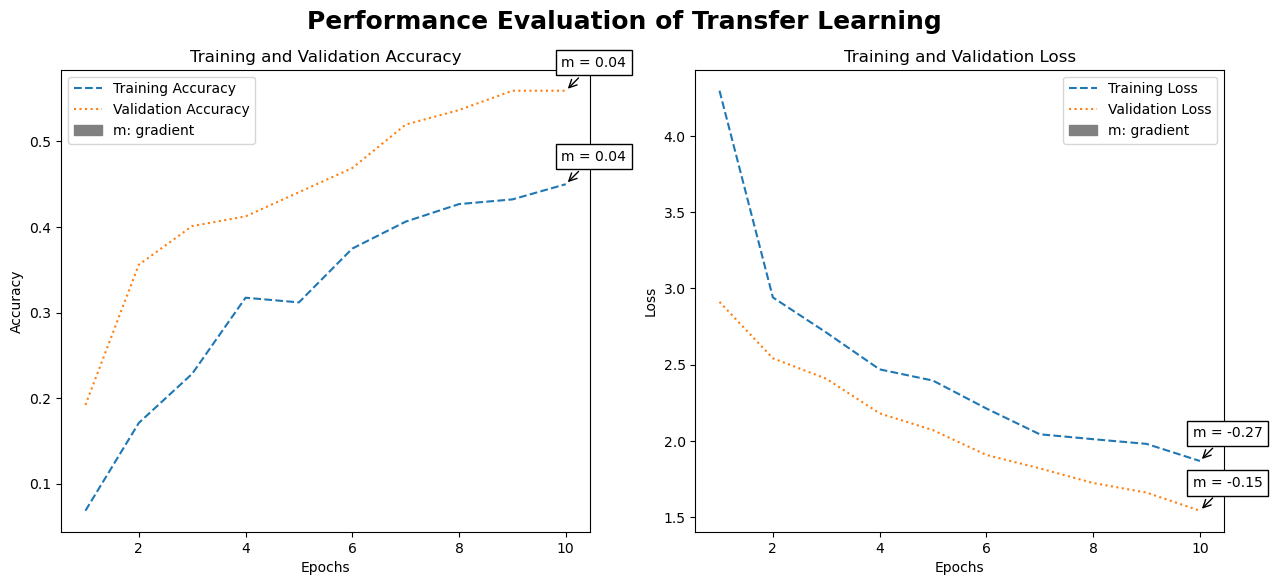

In [99]:
history_dict_2 = history_2.history
vis_evaluation(history_dict_2, 'Transfer Learning')

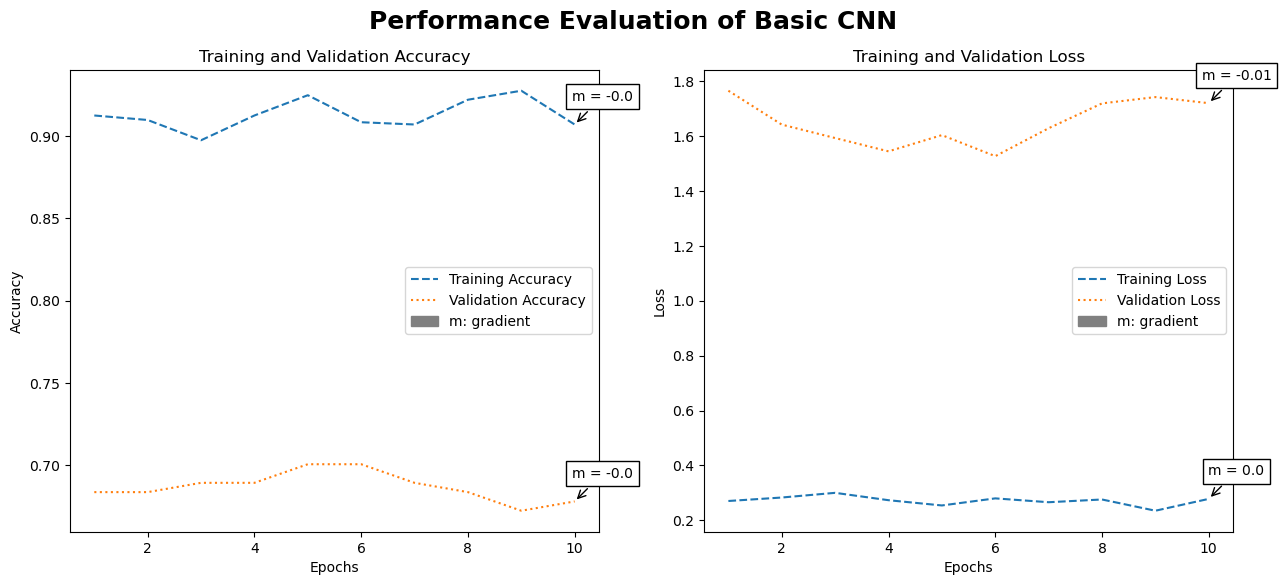

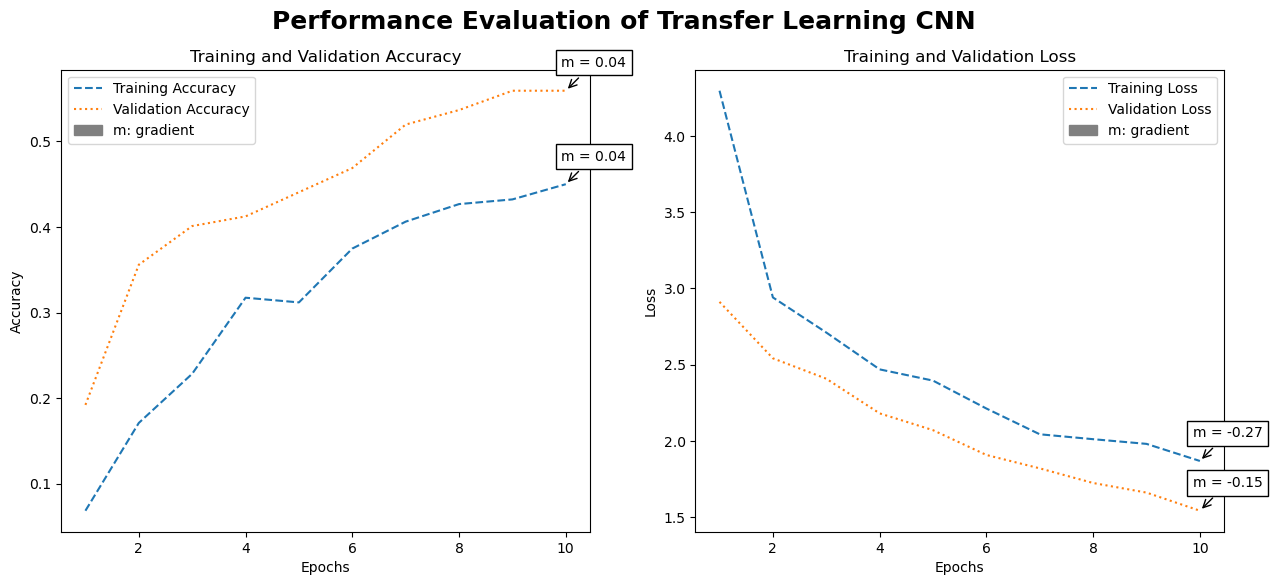

In [100]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.offsetbox import AnnotationBbox, TextArea

def vis_evaluation(history_dict, model_name):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    epochs = range(1, len(history_dict['accuracy']) + 1)

    def get_gradient(y_arr, epochs):
        return round((y_arr[-1] - y_arr[0]) / (epochs[-1] - epochs[0]), 2)

    def vis_sub_evaluation(n, Accuracy, train_acc, val_acc, epochs):
        axs[n].plot(epochs, train_acc, label=f'Training {Accuracy}', ls='--')
        axs[n].plot(epochs, val_acc, label=f'Validation {Accuracy}', ls='dotted')

        axs[n].set_title(f'Training and Validation {Accuracy}')
        axs[n].set_xlabel('Epochs')
        axs[n].set_ylabel(Accuracy)
        
        handles, labels = axs[n].get_legend_handles_labels()
        m_patch = mpatches.Patch(color='grey', label='m: gradient')
        handles.append(m_patch)
        axs[n].legend(handles=handles)
        
        def annotate_box(acc):
            return AnnotationBbox(TextArea(f"m = {get_gradient(acc, epochs)}"), (epochs[-1], acc[-1]),
                                  xybox=(20, 20),
                                  xycoords='data',
                                  boxcoords="offset points",
                                  arrowprops=dict(arrowstyle="->"))
        
        axs[n].add_artist(annotate_box(train_acc))
        axs[n].add_artist(annotate_box(val_acc))

    train_acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    vis_sub_evaluation(0, 'Accuracy', train_acc, val_acc, epochs)

    train_loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    vis_sub_evaluation(1, 'Loss', train_loss, val_loss, epochs)
    
    plt.suptitle(f"Performance Evaluation of {model_name}", fontsize=18, fontweight='bold')
    plt.show()

history_dict_cnn = history_1.history
history_dict_transfer_learning = history_2.history

vis_evaluation(history_dict_cnn, 'Basic CNN')
vis_evaluation(history_dict_transfer_learning, 'Transfer Learning CNN')
